# About This Notebook

This notebook demonstrate how to use ML Workbench to create a regression model that accepts numeric and categorical data. This one shows "local run" mode, which does most work (except for exporting data from Bigquery) on Datalab's VM. And it uses only 0.3% of the data (about 200K instances). Next notebook demonstrates how to deal with large data (~70M instances) by running every steps in Google Cloud.

Execution of this notebook requires Google Datalab (see [setup instructions](https://cloud.google.com/datalab/docs/quickstarts)).



# The Data

We will use [Chicago Taxi Trip Data](https://cloud.google.com/bigquery/public-data/chicago-taxi). Using pickup location, drop off location, taxi company, the model we will build predicts the trip fare.

## Sample Data from BigQuery and Export it to DataFrame

We will use the following query to get our training data.

Note that we convert weekday, day, hour to STRING so that they can be used as categorical instead of numeric features.

In [1]:
%%bq query --name texi_query
SELECT
  unique_key,
  fare,
  CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM trip_start_timestamp) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM trip_start_timestamp) AS STRING) as hour,
  taxi_id,
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude,
  company
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 
  fare > 2.0 AND fare < 200.0 AND
  pickup_latitude IS NOT NULL AND
  pickup_longitude IS NOT NULL AND
  dropoff_latitude IS NOT NULL AND
  dropoff_longitude IS NOT NULL AND
  taxi_id IS NOT NULL

In [5]:
# Sample 0.3% data, and split it into train/eval set.

import google.datalab.bigquery as bq
import numpy as np

sampling = bq.Sampling.random(percent=0.3)
job = texi_query.execute(sampling=sampling)
df = job.result().to_dataframe()
msk = np.random.rand(len(df)) < 0.95
train_df = df[msk]
eval_df = df[~msk]


In [6]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 219338 instances.
Eval set includes 11527 instances.


## Explore Data

Before we use the data, we need to explore it. In reality, data exploration/feature engineering is an iterative process. For example, the above query is impacted by data exploration (fare < 200, pickup_latitude IS NOT NULL, etc).

To explore data, we need some visualizations. We will use Facets visualization components -- Facets Overview and Diveview. They are both included in Datalab.

In [7]:
# Sample data before we visualize.

sample_train_df = train_df.sample(n=2000)
sample_eval_df = eval_df.sample(n=2000)

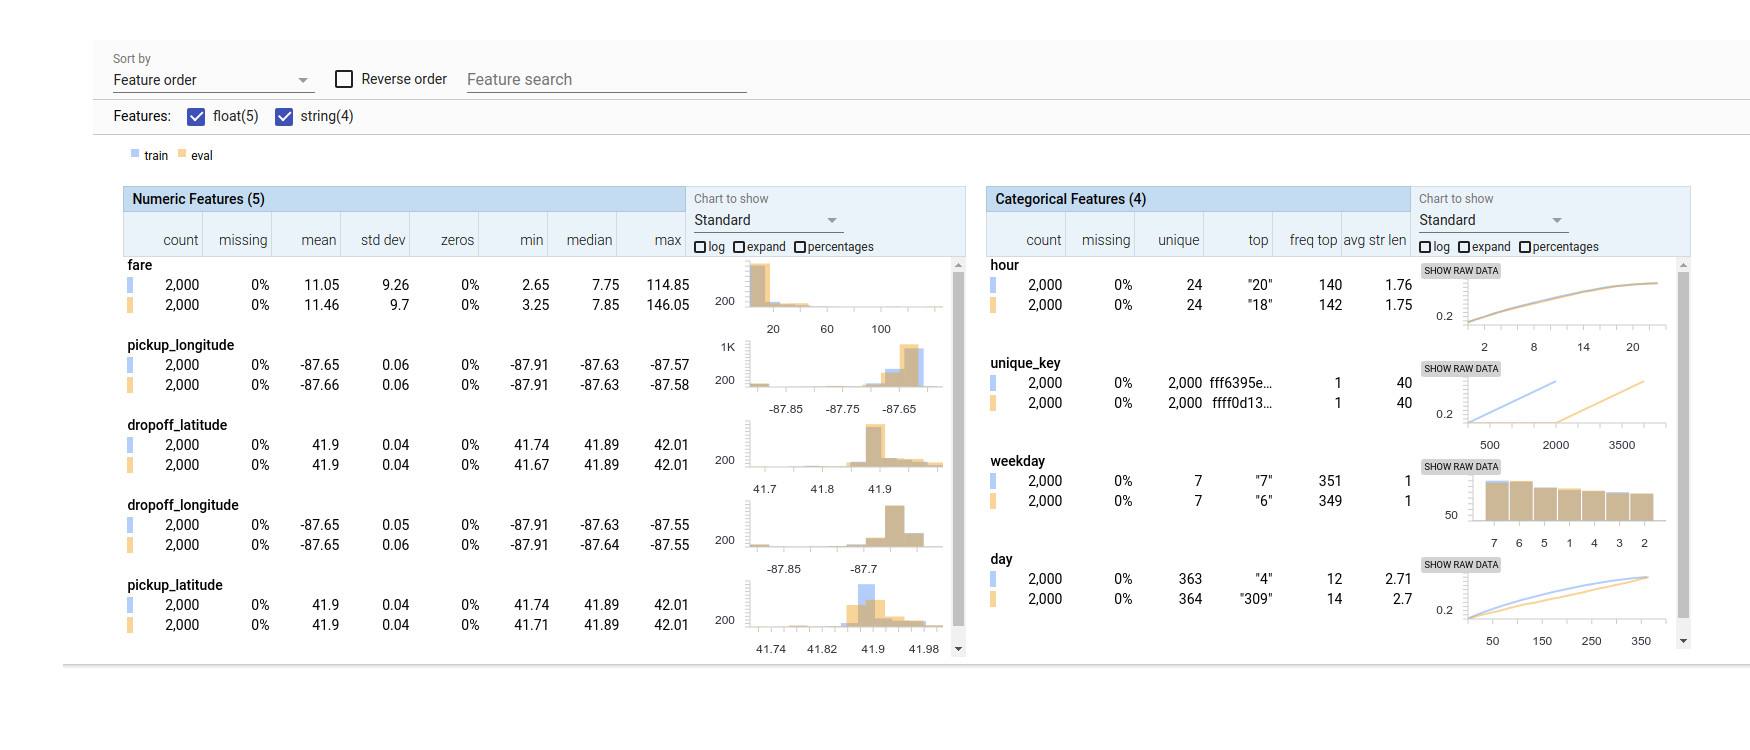

In [10]:
# Note: the interactive output is replaced with a static image so it displays well in github.
# Please execute this cell to see the interactive component.

from google.datalab.ml import FacetsOverview

FacetsOverview().plot({'train': sample_train_df, 'eval': sample_eval_df})

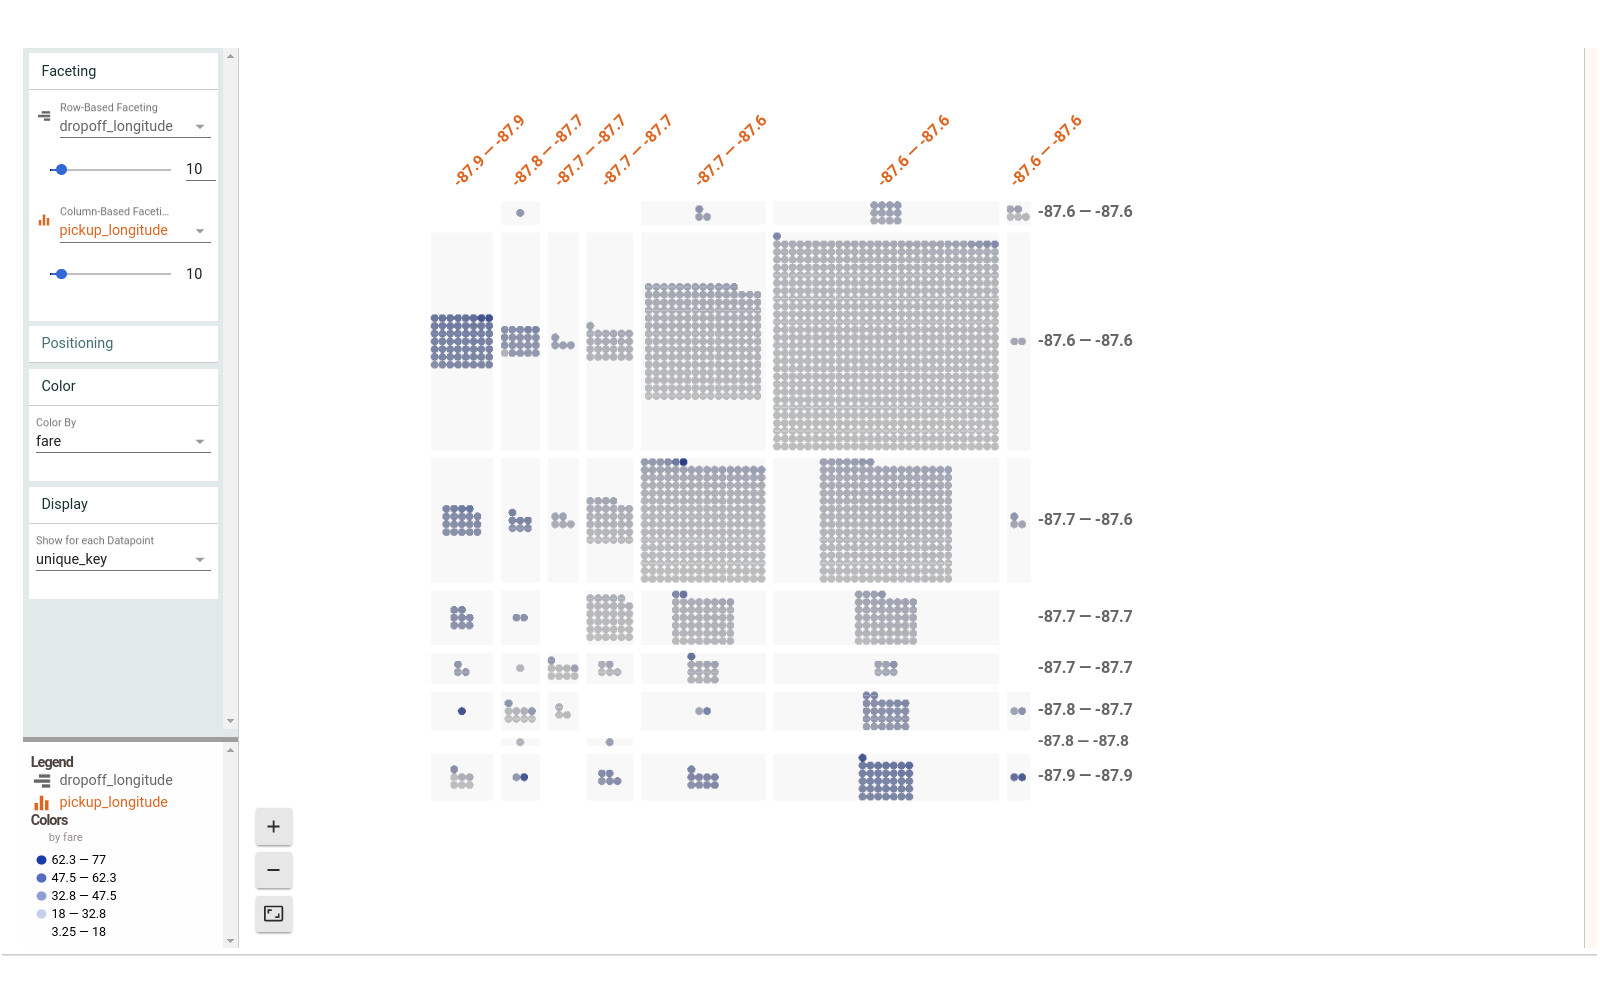

In [12]:
# Note: the interactive output is replaced with a static image so it displays well in github.
# Please execute this cell to see the interactive component.

from google.datalab.ml import FacetsDiveview

FacetsDiveview().plot(sample_train_df)

## Save Data

Save the data for model training.

In [14]:
!mkdir -p ./taxi

In [15]:
train_df.to_csv('./taxi/train.csv', header=False, index=False)
eval_df.to_csv('./taxi/eval.csv', header=False, index=False)

# Create Model with ML Workbench


The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the sampled data and build a regression model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

When the dataset is small, there is little benefit of using cloud services. This notebook will run the analyze, transform, and training steps locally. However, we will take the locally trained model and deploy it to ML Engine and show how to make real predictions on a deployed model. Every MLWorkbench magic can run locally or use cloud services (adding --cloud flag).

The next notebook in this sequence shows the cloud version of every command, and we will use full data.

In [1]:
import google.datalab.contrib.mlworkbench.commands # this loads the %%ml commands

## Step 1: Analyze

The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. Analysis in this case builds vocabulary for categorical features, and compute numeric stats for numeric features.

In [2]:
!rm -r -f ./taxi/analysis # Delete previous run results.

In [3]:
%%ml analyze
output: ./taxi/analysis
training_data:
  csv: ./taxi/train.csv
  schema:
    - name: unique_key
      type: STRING
    - name: fare
      type: FLOAT
    - name: weekday
      type: STRING
    - name: day
      type: STRING
    - name: hour
      type: STRING
    - name: taxi_id
      type: STRING
    - name: pickup_latitude
      type: FLOAT
    - name: pickup_longitude
      type: FLOAT
    - name: dropoff_latitude
      type: FLOAT
    - name: dropoff_longitude
      type: FLOAT
    - name: company
      type: STRING
features:
  unique_key:
    transform: key
  fare:
    transform: target   
  weekday:
    transform: one_hot
  day:
    transform: one_hot
  hour:
    transform: one_hot      
  taxi_id:
    transform: embedding
    embedding_dim: 50
  pickup_latitude:
    transform: scale    
  pickup_longitude:
    transform: scale
  dropoff_latitude:
    transform: scale
  dropoff_longitude:
    transform: scale
  company:
    transform: embedding
    embedding_dim: 10      

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_classification_taxi/taxi/train.csv...
file /content/datalab/docs/samples/contrib/mlworkbench/structured_data_classification_taxi/taxi/train.csv analyzed.


## Step 2: Transform

This step is optional as training can start from csv data (the same data used in the analysis step). The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocol buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can speed up training.

We run the transform step for the training and eval data.

In [4]:
!rm -r -f ./taxi/transform # Delete previous run results.

In [5]:
%%ml transform
output: ./taxi/transform
analysis: ./taxi/analysis
prefix: train
training_data:
  csv: ./taxi/train.csv

2017-09-08 00:05:35.375610: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:05:35.375650: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:05:35.375681: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:05:35.375699: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:05:35.375725: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [6]:
%%ml transform
output: ./taxi/transform
analysis: ./taxi/analysis
prefix: eval
training_data:
  csv: ./taxi/eval.csv

2017-09-08 00:07:07.509783: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:07:07.509820: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:07:07.509841: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:07:07.509854: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-09-08 00:07:07.509878: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

## Step 3: Training

MLWorkbench help build standard TensorFlow models without you having to write any TensorFlow code. 

In [8]:
# Delete previous run results.
!rm -r -f ./taxi/linear_train
!rm -r -f ./taxi/dnn_train 

### Linear Regression Model

Let's build a linear model first.

In [9]:
%%ml train
output: ./taxi/linear_train
analysis: ./taxi/analysis
training_data:
    transformed: ./taxi/transform/train-*
evaluation_data:
    transformed: ./taxi/transform/eval-*
model_args:
    model: linear_regression
    max-steps: 10000
    save-checkpoints-secs: 15
    train-batch-size: 1000
    eval-batch-size: 1000
    learning-rate: 0.1

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 15, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4886590d90>, '_model_dir': '/content/datalab/docs/samples/contrib/mlworkbench/structured_data_classification_taxi/taxi/linear_train/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based 

Last loss value is 50.9953, so RMSE is around 7.14 (sqrt(50.9953)). You can run the following to start a TensorBoard to see the details.

In [11]:
from google.datalab.ml import TensorBoard

TensorBoard.start('./taxi/linear_train')

TensorBoard was started successfully with pid 4958. Click here to access it.

4958

Or, you may want to plot the events inside notebook for sharing or presentation.

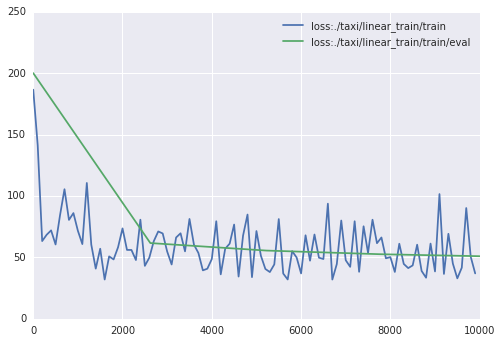

In [10]:
from google.datalab.ml import Summary

summary = Summary('./taxi/linear_train')
summary.plot('loss')

### DNN Regression Model

RMSE = 7.14 is not very impressive. Let's see if we can do better with a DNN regression model. Note that some preliminary hyperparam search has been done. You may get better results by tweaking the hyperparams.

In [12]:
%%ml train
output: ./taxi/dnn_train
analysis: ./taxi/analysis
training_data:
    transformed: ./taxi/transform/train-*
evaluation_data:
    transformed: ./taxi/transform/eval-*
model_args:
    model: dnn_regression
    max-steps: 3000
    save-checkpoints-secs: 30
    hidden-layer-size1: 400
    hidden-layer-size2: 200
    train-batch-size: 1000
    eval-batch-size: 1000
    learning-rate: 0.001

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 30, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3834f2a0d0>, '_model_dir': '/content/datalab/docs/samples/contrib/mlworkbench/structured_data_classification_taxi/taxi/dnn_train/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on 

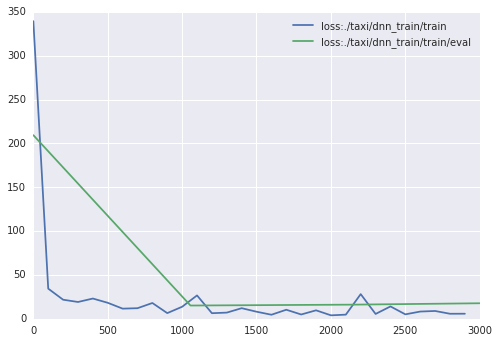

In [13]:
summary = Summary('./taxi/dnn_train')
summary.plot('loss')

Loss = 17.71, and RMSE is about 4.21. It seems DNN model performs much better than linear. It is not surprising because trip fare is probably not "very" linear to any features. Instead we need to build some non-linear activations into the model, which is exactly what DNN does.

## Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is needed for large datasets where the data cannot fit in memory. For demo purpose, we will use the evaluation data again.

In [184]:
!rm -r -f ./taxi/batch_predict # Delete previous results.

There are two model dirs under our training dir: "evaluation_model" and "model". The difference between these two is that evaluation model expects input with target (truth) value, while regular model expects no target column. Evaluation model outputs the input target value as is. Because it outputs both target and predicted value, it is good for model evaluation.

In [15]:
!ls ./taxi/dnn_train/

evaluation_model  model  schema_without_target.json  train


In [14]:
%%ml batch_predict
model: ./taxi/dnn_train/evaluation_model/
output: ./taxi/batch_predict
format: csv
prediction_data:
  csv: ./taxi/eval.csv
batch_size: 1000    

local prediction...
INFO:tensorflow:Restoring parameters from ./taxi/dnn_train/evaluation_model/variables/variables
done.


In [16]:
!ls ./taxi/batch_predict

predict_results_eval.csv  predict_results_schema.json


In [18]:
!head ./taxi/batch_predict/predict_results_eval.csv

8.89497,10.25,cacd255b228cae40828feb8575b7d51d01f7c30e
10.2042,10.25,d41200b7ad9f1ae499a27eacec13ccebd3f227e4
6.79416,10.85,d36e0da792ff7d075a31460945a473fd91f1770b
9.39757,10.85,fc76a80b2bf882d466478e5945b8a5e746ab2226
6.15031,7.45,7748557ab71f69bae4b793abe8e87c5b114ac2f8
13.2482,9.65,51f78a904cfceef195ea175f47e99b55743dd8f7
6.34229,7.45,d907ff3c81b63e5caa4592a0187de213d4bcda29
9.91101,11.65,1c44f03d056966b31d7bfc868484968367e3d05d
7.27177,9.05,6b73ff9d1f7c24aec84dd6bcd4e4d2a54d53e585
9.14632,9.65,e7d3b31825baee7f754308506a8cc32b7fa08ac9


Note that the "predict_results_schema.json" file includes the csv schema of "predict_results_eval.csv".

In [21]:
# Compute RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

df = pd.read_csv('./taxi/batch_predict/predict_results_eval.csv', names=['predicted', 'target', 'key'])
rms = sqrt(mean_squared_error(df['target'], df['predicted']))

print('DNN Model RMSE: %f' % rms)

DNN Model RMSE: 4.227401


# Prediction

The MLWorkbench supports running prediction and displaying the results within the notebook.

## Local Prediction

Note that now we use the non-evaluation model below (./dnn_train/model) which takes input with no target column. The prediction data is taken from eval csv file with target (fare) column removed.

In [23]:
%%ml predict
model: ./taxi/dnn_train/model/
prediction_data:
  - cacd255b228cae40828feb8575b7d51d01f7c30e,7,201,21,25d14a6b429ecc54f2b698138ad74b351829a70fdff7887ba12ecf5597880f9c7aa6b097306b088316356779cf11b0a1533ee4c74e1024ec96aa338bf7bfa3f0,41.912364354,-87.675062757,41.892042136,-87.63186395,
  - d41200b7ad9f1ae499a27eacec13ccebd3f227e4,1,327,0,cd4fd4495559f5b37d60aa798873aa96ebc35da5d9a38d05a81f8d101f251af79b47c165d67c31a028776e2243ba3a3ac70e7cf86b1981913940a5679cef8db2,41.912364354,-87.675062757,41.949060526,-87.661642904,Northwest Management LLC
  - d36e0da792ff7d075a31460945a473fd91f1770b,6,262,19,c57f50c1ccf2d3fbacc095ae98c0cffc0db11194f04c3d0cd247b97c45b417587dbfd559e0be85df07fce7b4f35bbf035858466a11f98b085d7c30ecd294e24b,41.912364354,-87.675062757,41.914747305,-87.654007029,

predicted,unique_key,company,day,dropoff_latitude,dropoff_longitude,hour,pickup_latitude,pickup_longitude,taxi_id,weekday
8.894969,cacd255b228cae40828feb8575b7d51d01f7c30e,,201,41.892042136,-87.63186395,21,41.912364354,-87.675062757,25d14a6b429ecc54f2b698138ad74b351829a...,7
10.204162,d41200b7ad9f1ae499a27eacec13ccebd3f227e4,Northwest Management LLC,327,41.949060526,-87.661642904,0,41.912364354,-87.675062757,cd4fd4495559f5b37d60aa798873aa96ebc35...,1
6.794156,d36e0da792ff7d075a31460945a473fd91f1770b,,262,41.914747305,-87.654007029,19,41.912364354,-87.675062757,c57f50c1ccf2d3fbacc095ae98c0cffc0db11...,6


## Online Prediction

Datalab includes a prediction client for online (deployed) models.

### Deploy Model
We can deploy locally trained model online so it can serve prediction requests via http. To deploy a local model, we'll need:

1. Enable Machine Learning API in your Google Cloud project.
2. Have a staging GCS location ready.

In [24]:
# Create a staging GCS bucket

!gsutil mb gs://datalab-taxi-local-model-staging

Creating gs://datalab-taxi-local-model-staging/...


In [26]:
# Copy model files over.

!gsutil cp -r ./taxi/dnn_train/model gs://datalab-taxi-local-model-staging/model

Copying file://./taxi/dnn_train/model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./taxi/dnn_train/model/assets.extra/features.json [Content-Type=application/json]...
Copying file://./taxi/dnn_train/model/assets.extra/schema.json [Content-Type=application/json]...
Copying file://./taxi/dnn_train/model/variables/variables.index [Content-Type=application/octet-stream]...
\ [4 files][846.5 KiB/846.5 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://./taxi/dnn_train/model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
| [5 files][  2.8 MiB/  2.8 MiB]                                                
Operation completed over 5 objects/2.8 MiB.                     

In [28]:
# Deploy model.

from google.datalab.ml import Models, ModelVersions

# Makes a ML Engine Model
try:
    Models().create('chicago_taxi')  
except:
    # If model exists.
    pass

# Makes a ML Engine Version
ModelVersions('chicago_taxi').deploy(
    version_name='local',
    path='gs://datalab-taxi-local-model-staging/model')

Waiting for operation "projects/bradley-playground/operations/create_chicago_taxi_local-1504832147586"
Done.


### Prediction with Online Model

Once model is deployed, "%%ml predict" can be used in Datalab for online prediction. Note that "--cloud" is needed to indicate the model is online, and "model" value should be "model.version". Also, for now, you still need to specify headers of the csv line.

In [32]:
%%ml predict --cloud
model: chicago_taxi.local
headers: unique_key,weekday,day,hour,taxi_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company
prediction_data:
  - cacd255b228cae40828feb8575b7d51d01f7c30e,7,201,21,25d14a6b429ecc54f2b698138ad74b351829a70fdff7887ba12ecf5597880f9c7aa6b097306b088316356779cf11b0a1533ee4c74e1024ec96aa338bf7bfa3f0,41.912364354,-87.675062757,41.892042136,-87.63186395,
  - d41200b7ad9f1ae499a27eacec13ccebd3f227e4,1,327,0,cd4fd4495559f5b37d60aa798873aa96ebc35da5d9a38d05a81f8d101f251af79b47c165d67c31a028776e2243ba3a3ac70e7cf86b1981913940a5679cef8db2,41.912364354,-87.675062757,41.949060526,-87.661642904,Northwest Management LLC
  - d36e0da792ff7d075a31460945a473fd91f1770b,6,262,19,c57f50c1ccf2d3fbacc095ae98c0cffc0db11194f04c3d0cd247b97c45b417587dbfd559e0be85df07fce7b4f35bbf035858466a11f98b085d7c30ecd294e24b,41.912364354,-87.675062757,41.914747305,-87.654007029,

predicted,unique_key,company,day,dropoff_latitude,dropoff_longitude,hour,pickup_latitude,pickup_longitude,taxi_id,weekday
8.894969,cacd255b228cae40828feb8575b7d51d01f7c30e,,201,41.892042136,-87.63186395,21,41.912364354,-87.675062757,25d14a6b429ecc54f2b698138ad74b351829a...,7
10.204162,d41200b7ad9f1ae499a27eacec13ccebd3f227e4,Northwest Management LLC,327,41.949060526,-87.661642904,0,41.912364354,-87.675062757,cd4fd4495559f5b37d60aa798873aa96ebc35...,1
6.794156,d36e0da792ff7d075a31460945a473fd91f1770b,,262,41.914747305,-87.654007029,19,41.912364354,-87.675062757,c57f50c1ccf2d3fbacc095ae98c0cffc0db11...,6


### Build your own prediction client with Python

A common task is to call a deployed model from different applications. Below is an example of writing a python client to run prediction outside of Datalab.

For more information about model permissions, see https://cloud.google.com/ml-engine/docs/tutorials/python-guide and https://developers.google.com/identity/protocols/application-default-credentials .

In [37]:
import json
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=google.datalab.Context.default().project_id,
    model_name='chicago_taxi',
    version_name='local')

# Get application default credentials (possible only if the gcloud tool is
#  configured on your machine). See https://developers.google.com/identity/protocols/application-default-credentials
#  for more info.
credentials = GoogleCredentials.get_application_default()

# Build a representation of the Cloud ML API.
ml = discovery.build('ml', 'v1', credentials=credentials)

# Create a dictionary containing data to predict.
# Note that the data is a list of csv strings.
body = {
    'instances': [
        'cacd255b228cae40828feb8575b7d51d01f7c30e,7,201,21,25d14a6b429ecc54f2b698138ad74b351829a70fdff7887ba12ecf5597880f9c7aa6b097306b088316356779cf11b0a1533ee4c74e1024ec96aa338bf7bfa3f0,41.912364354,-87.675062757,41.892042136,-87.63186395,',
        'd41200b7ad9f1ae499a27eacec13ccebd3f227e4,1,327,0,cd4fd4495559f5b37d60aa798873aa96ebc35da5d9a38d05a81f8d101f251af79b47c165d67c31a028776e2243ba3a3ac70e7cf86b1981913940a5679cef8db2,41.912364354,-87.675062757,41.949060526,-87.661642904,Northwest Management LLC',
        'd36e0da792ff7d075a31460945a473fd91f1770b,6,262,19,c57f50c1ccf2d3fbacc095ae98c0cffc0db11194f04c3d0cd247b97c45b417587dbfd559e0be85df07fce7b4f35bbf035858466a11f98b085d7c30ecd294e24b,41.912364354,-87.675062757,41.914747305,-87.654007029,',
    ]
}

# Create a request
request = ml.projects().predict(
    name=api_path,
    body=body)

# Make the call.
try:
    response = request.execute()
    print('\nThe response:\n')
    print(json.dumps(response, indent=2))
except errors.HttpError, err:
    # Something went wrong, print out some information.
    print('There was an error. Check the details:')
    print(err._get_reason())


The response:

{
  "predictions": [
    {
      "predicted": 8.89496898651123, 
      "unique_key": "cacd255b228cae40828feb8575b7d51d01f7c30e"
    }, 
    {
      "predicted": 10.204161643981934, 
      "unique_key": "d41200b7ad9f1ae499a27eacec13ccebd3f227e4"
    }, 
    {
      "predicted": 6.794156074523926, 
      "unique_key": "d36e0da792ff7d075a31460945a473fd91f1770b"
    }
  ]
}


# Clean up

In [ ]:
# Delete the version
ModelVersions('chicago_taxi').delete('local')

# Delete model
Models().delete('chicago_taxi')

# Delete the GCS bucket
!gsutil -m rm -r gs://datalab-taxi-local-model-staging